# BATTLE OF NEIGHBOURHOODS

### This business problem performs a comparison of the two cities, i.e. Toronto and New York to determine how similar or dissimilar they are based on available amenities or services within the areas. This type of case or problem study was selected because it serves a lot of purposes other than selecting a place where to live or migrate. 

### The problem statement is: Is Toronto more like New York City before a family decides to migrate to Toronto? There are several factors to assess or compare places or cities like population, crime rate, cost of living, and others. For this case study, it will leverage or focus on the Foursquare location and available data to explore or compare the Toronto and New York cities and/or their neighbourhoods.

## Import packages/libraries

In [1]:
import numpy as np     # library to handle data in a vectorized manner
import pandas as pd    # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import requests                           # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#BeautifulSoup
from bs4 import BeautifulSoup

print('Packages/Libraries imported.')

Packages/Libraries imported.


## Get data from source, preprocess and convert into dataframes

In [2]:
#Toronto Data

url1 = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"  
toronto_df=pd.read_html(url1, header=0)[0]

#Preprocessing of Needed Data

#Rename Postal Code to PostalCode
toronto_df.rename(columns={'Postal Code':'Postcode'}, inplace=True)

#Drop Burough='Not assigned'
toronto_df = toronto_df[toronto_df.Borough != 'Not assigned'].reset_index(drop=True)

#Merge neighbourhoods with duplicates postal code
toronto_df = toronto_df.groupby(['Postcode','Borough'], as_index=False).agg(lambda x: ','.join(x))

#Mask Neighbourhood='Not assigned' with Borough
mask1 = toronto_df['Neighbourhood'] == "Not assigned"
toronto_df.loc[mask1, 'Neighbourhood'] = toronto_df.loc[mask1, 'Borough']

#Get latitude & longitude coordinates of Toronto
coord_df = pd.read_csv("http://cocl.us/Geospatial_data")
coord_df.rename(columns={'Postal Code':'Postcode'}, inplace=True)
coord_df.set_index("Postcode")
toronto_df.set_index("Postcode")
toronto_df=pd.merge(toronto_df, coord_df)
toronto_df.drop('Postcode', axis=1, inplace=True)
print('Toronto Size/Shape : ', toronto_df.shape, '\n')
toronto_df

Toronto Size/Shape :  (103, 4) 



,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476
5,Scarborough,Scarborough Village,43.744734,-79.239476
6,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [3]:
#New York Data
#Source=https://cocl.us/new_york_dataset for New York

def get_new_york_data():
    url2='https://cocl.us/new_york_dataset'
    resp=requests.get(url2).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

newyork_df = get_new_york_data()
newyork_df.rename(columns={'Neighborhood':'Neighbourhood'}, inplace=True)
print('New York Size/Shape : ', newyork_df.shape, '\n')
newyork_df


New York Size/Shape :  (306, 4) 



,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


## Get Statistics

In [4]:
#Statistics - No. of Boroughs & Neighbourhoods

city1 = 'Toronto'
toronto_noofbor = len(toronto_df['Borough'].unique())
toronto_noofnei = len(toronto_df['Neighbourhood'].unique())

city2 = 'New York'
newyork_noofbor = len(newyork_df['Borough'].unique())
newyork_noofnei = len(newyork_df['Neighbourhood'].unique())

#Create the statistics table of boroughs & neighbourhoods
stat_cols = ['City', 'Boroughs', 'Neighbourhoods']
stat1_df = pd.DataFrame(columns = stat_cols)

#Insert the data into the statistics table
stat1_df = stat1_df.append({'City': city1, 'Boroughs': toronto_noofbor, 'Neighbourhoods': toronto_noofnei}, ignore_index=True)
stat1_df = stat1_df.append({'City': city2, 'Boroughs': newyork_noofbor, 'Neighbourhoods': newyork_noofnei}, ignore_index=True)
stat1_df

,City,Boroughs,Neighbourhoods
0,Toronto,10,99
1,New York,5,302


## Create Maps

### Note: Results of Maps saved in another file and stored in GitHub repository too.

In [5]:
#In order to define an instance of the geocoder, define a user_agent. 
#name is agent to_explorer
import geocoder
geolocator = Nominatim(user_agent="to_explorer")
address1 = 'Toronto'
address2 = 'New York'
location1 = geolocator.geocode(address1)
location2 = geolocator.geocode(address2)
latitude1 = location1.latitude
longitude1 = location1.longitude
latitude2 = location2.latitude
longitude2 = location2.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude1, longitude1))
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude2, longitude2))


The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.
The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Toronto Map

In [6]:
map_toronto = folium.Map(location=[latitude1, longitude1], zoom_start=10)
for lat, lng, borough, neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

print('Toronto City coordinates are: Latitude = ', latitude1, ' Longitude = ', longitude1, '\n')
map_toronto

Toronto City coordinates are: Latitude =  43.6534817  Longitude =  -79.3839347 



### New York Map

In [7]:
map_newyork = folium.Map(location=[latitude2, longitude2], zoom_start=10)
for lat, lng, borough, neighbourhood in zip(newyork_df['Latitude'], newyork_df['Longitude'], newyork_df['Borough'], newyork_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
print('New York City coordinates are: Latitude = ', latitude2, ' Longitude = ', longitude2, '\n')
map_newyork

New York City coordinates are: Latitude =  40.7127281  Longitude =  -74.0060152 



## Exploring Data using Foursquare

In [8]:
#Foursquare credentials and necessary parameters

LIMIT=50

CLIENT_ID = 'E3K04ZL0VVFK2MVEFLTYLNF0XRRSHBAPHDBKZHNJ05HISIOE'     # your Foursquare ID
CLIENT_SECRET = 'NDM43A3WPHRAIPYWUAY1HFT3SSVPFXBYO2F5UNFAKAOQZ4QK' # your Foursquare Secret
VERSION = '20180604'                                               # Foursquare API version

print('Client ID = ', CLIENT_ID)
print('Client Secret = ', CLIENT_SECRET)
print('Version = ', VERSION)

Client ID =  E3K04ZL0VVFK2MVEFLTYLNF0XRRSHBAPHDBKZHNJ05HISIOE
Client Secret =  NDM43A3WPHRAIPYWUAY1HFT3SSVPFXBYO2F5UNFAKAOQZ4QK
Version =  20180604


### Exploring all neighbourhoods

In [9]:
#Explore all neighbourhoods in Toronto

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, bor, lat, lng in zip(names, boroughs, latitudes, longitudes):
        print(name, ' - ', bor, lat, lng)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            bor,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Borough',
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

print('getNearbyVenues done')


getNearbyVenues done


In [10]:
#Code to run the above function on each neighborhood and create a new dataframe called toronto_venues.
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'], 
                                   boroughs=toronto_df['Borough'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

print('\n', 'getNearbyVenues for Toronto done')
print('\n', 'Toronto Venues Shape ', toronto_venues.shape, '\n')

toronto_noofven = len(toronto_venues)
print('Toronto # of venues = ', toronto_noofven, 'Toronto shape : ', toronto_venues.shape)
toronto_venues.head()


Malvern, Rouge  -  Scarborough 43.806686299999996 -79.19435340000001
Rouge Hill, Port Union, Highland Creek  -  Scarborough 43.7845351 -79.16049709999999
Guildwood, Morningside, West Hill  -  Scarborough 43.7635726 -79.1887115
Woburn  -  Scarborough 43.7709921 -79.21691740000001
Cedarbrae  -  Scarborough 43.773136 -79.23947609999999
Scarborough Village  -  Scarborough 43.7447342 -79.23947609999999
Kennedy Park, Ionview, East Birchmount Park  -  Scarborough 43.7279292 -79.26202940000002
Golden Mile, Clairlea, Oakridge  -  Scarborough 43.711111700000004 -79.2845772
Cliffside, Cliffcrest, Scarborough Village West  -  Scarborough 43.716316 -79.23947609999999
Birch Cliff, Cliffside West  -  Scarborough 43.692657000000004 -79.2648481
Dorset Park, Wexford Heights, Scarborough Town Centre  -  Scarborough 43.7574096 -79.27330400000001
Wexford, Maryvale  -  Scarborough 43.750071500000004 -79.2958491
Agincourt  -  Scarborough 43.7942003 -79.26202940000002
Clarks Corners, Tam O'Shanter, Sullivan  

,Neighbourhood,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",Scarborough,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",Scarborough,43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Rouge Hill, Port Union, Highland Creek",Scarborough,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",Scarborough,43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",Scarborough,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [11]:
#Code to run the above function on each neighborhood and create a new dataframe called newyork_venues.
newyork_venues = getNearbyVenues(names=newyork_df['Neighbourhood'], boroughs=newyork_df['Neighbourhood'],
                                   latitudes=newyork_df['Latitude'],
                                   longitudes=newyork_df['Longitude']
                                  )

print('\n', 'getNearbyVenues for New York done')

print('\n', 'New York Venues Shape ', newyork_venues.shape, '\n')

newyork_noofven = len(newyork_venues)
print('New York # of venues = ', newyork_noofven, 'New York shape : ', newyork_venues.shape)
newyork_venues.head()

Wakefield  -  Wakefield 40.89470517661 -73.84720052054902
Co-op City  -  Co-op City 40.87429419303012 -73.82993910812398
Eastchester  -  Eastchester 40.887555677350775 -73.82780644716412
Fieldston  -  Fieldston 40.89543742690383 -73.90564259591682
Riverdale  -  Riverdale 40.890834493891305 -73.9125854610857
Kingsbridge  -  Kingsbridge 40.88168737120521 -73.90281798724604
Marble Hill  -  Marble Hill 40.87655077879964 -73.91065965862981
Woodlawn  -  Woodlawn 40.89827261213805 -73.86731496814176
Norwood  -  Norwood 40.87722415599446 -73.8793907395681
Williamsbridge  -  Williamsbridge 40.88103887819211 -73.85744642974207
Baychester  -  Baychester 40.866858107252696 -73.83579759808117
Pelham Parkway  -  Pelham Parkway 40.85741349808865 -73.85475564017999
City Island  -  City Island 40.84724670491813 -73.78648845267413
Bedford Park  -  Bedford Park 40.870185164975325 -73.8855121841913
University Heights  -  University Heights 40.85572707719664 -73.9104159619131
Morris Heights  -  Morris Heig

,Neighbourhood,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [12]:
#Add venue statistics on stat1_df
stat1_df=stat1_df.assign(Venues = [toronto_noofven, newyork_noofven])
stat1_df

,City,Boroughs,Neighbourhoods,Venues
0,Toronto,10,99,1671
1,New York,5,302,7824


In [13]:
#No. of venues for each neighbourhood of Toronto
toronto_groupdf = toronto_venues.groupby('Neighbourhood').count()
print('\n', 'Toronto Groupby Neighbourhood Shape ', toronto_groupdf.shape, '\n')
toronto_groupdf.head()


 Toronto Groupby Neighbourhood Shape  (94, 7) 



,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,
Agincourt,5,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24,24


In [14]:
#No. of venues for each neighbourhood of New York
newyork_groupdf = newyork_venues.groupby('Neighbourhood').count()
print('\n', 'New York Groupby Neighbourhood Shape ', newyork_groupdf.shape, '\n')
newyork_groupdf.head()


 New York Groupby Neighbourhood Shape  (301, 7) 



,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,
Allerton,31,31,31,31,31,31,31
Annadale,12,12,12,12,12,12,12
Arden Heights,5,5,5,5,5,5,5
Arlington,5,5,5,5,5,5,5
Arrochar,22,22,22,22,22,22,22


In [15]:
#No. of unique categories - Toronto & New York

toronto_noofuniq = len(toronto_venues['Venue Category'].unique())
newyork_noofuniq = len(newyork_venues['Venue Category'].unique())

print('Unique venue categories of Toronto = ', toronto_noofuniq)
print('Unique venue categories of New York = ', newyork_noofuniq)

stat1_df=stat1_df.assign(UniqueCategories = [toronto_noofuniq, newyork_noofuniq])
stat1_df


Unique venue categories of Toronto =  251
Unique venue categories of New York =  412


,City,Boroughs,Neighbourhoods,Venues,UniqueCategories
0,Toronto,10,99,1671,251
1,New York,5,302,7824,412


### One Hot Encoding

In [16]:
# one hot encoding - Toronto
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
print('\n', 'Toronto one hot encoding Shape ', toronto_onehot.shape, '\n')
toronto_onehot.head()


 Toronto one hot encoding Shape  (1671, 252) 



,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [17]:
# one hot encoding - New York
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
newyork_onehot['Neighbourhood'] = newyork_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]
print('\n', 'New York one hot encoding Shape ', newyork_onehot.shape, '\n')
newyork_onehot.head()


 New York one hot encoding Shape  (7824, 413) 



,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,P

In [18]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category - Toronto

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print('\n', 'Toronto Grouped using one hot encoding Shape ', toronto_grouped.shape, '\n')
toronto_grouped.head()



 Toronto Grouped using one hot encoding Shape  (94, 252) 



,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,

In [19]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category - New York

newyork_grouped = newyork_onehot.groupby('Neighbourhood').mean().reset_index()
print('\n', 'New York Grouped using one hot encoding Shape ', newyork_grouped.shape, '\n')
newyork_grouped.head()



 New York Grouped using one hot encoding Shape  (301, 413) 



,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,P

### Neighbourhoods along with the top 10 most common venues

In [20]:
#Toronto neighborhoods along with the top 10 most common venues
num_top_venues = 10

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Agincourt----
                             venue  freq
0                   Clothing Store   0.2
1                   Breakfast Spot   0.2
2                           Lounge   0.2
3        Latin American Restaurant   0.2
4                     Skating Rink   0.2
5               Miscellaneous Shop   0.0
6              Monument / Landmark   0.0
7  Molecular Gastronomy Restaurant   0.0
8       Modern European Restaurant   0.0
9                Mobile Phone Shop   0.0


----Alderwood, Long Branch----
                      venue  freq
0               Pizza Place  0.29
1               Coffee Shop  0.14
2                       Pub  0.14
3              Skating Rink  0.14
4                       Gym  0.14
5            Sandwich Place  0.14
6            Medical Center  0.00
7  Mediterranean Restaurant  0.00
8               Men's Store  0.00
9            Massage Studio  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                       Bank  0

In [21]:
#Put data into a pandas dataframe
#Function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)  
    return row_categories_sorted.index.values[0:num_top_venues]

#Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_neighborhoods_venues_sorted.head(20)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Clothing Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Pub,Skating Rink,Gym,Coffee Shop,Sandwich Place,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Grocery Store,Supermarket,Shopping Mall,Bridal Shop,Sandwich Place,Restaurant,Pizza Place,Park
3,Bayview Village,Bank,Japanese Restaurant,Chinese Restaurant,Café,Yoga Studio,Dog Run,Diner,Discount Store,Distribution Center,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Hobby Shop,Italian Restaurant,Coffee Shop,Pharmacy,Butcher,Café,Restaurant,Pub,Pizza Place
5,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Seafood Restaurant,Restaurant,Farmers Market,Bakery,Cheese Shop,Concert Hall,Bistro
6,"Birch Cliff, Cliffside West",College Stadium,Café,Skating Rink,General Entertainment,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
7,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Breakfast Spot,Coffee Shop,Yoga Studio,Gym,Pet Store,Performing Arts Venue,Nightclub,Italian Restaurant
8,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Brewery,Gym / Fitness Center,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Plane,Harbor / Marina,Rental Car Location,Sculpture Garden,Boat or Ferry,Boutique,Airport Food Court,Airport Lounge


In [22]:
print('\n', 'Toronto 10 Most Common Shape ', toronto_neighborhoods_venues_sorted.shape, '\n')


 Toronto 10 Most Common Shape  (94, 11) 



In [23]:
#New York neighborhoods along with the top 10 most common venues
num_top_venues = 10

for hood in newyork_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

#Put data into a pandas dataframe
#Function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)  
    return row_categories_sorted.index.values[0:num_top_venues]

#Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
newyork_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_venues_sorted['Neighbourhood'] = newyork_grouped['Neighbourhood']

for ind in np.arange(newyork_grouped.shape[0]):
    newyork_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

print('\n', 'New York 10 Most Common Shape ', newyork_neighborhoods_venues_sorted.shape, '\n')
newyork_neighborhoods_venues_sorted.head(20)

----Allerton----
                   venue  freq
0            Pizza Place  0.16
1          Deli / Bodega  0.06
2            Supermarket  0.06
3            Bus Station  0.06
4                    Spa  0.06
5     Chinese Restaurant  0.06
6      Electronics Store  0.03
7    Martial Arts School  0.03
8   Fast Food Restaurant  0.03
9  Check Cashing Service  0.03


----Annadale----
                 venue  freq
0          Pizza Place  0.25
1                Diner  0.08
2     Sushi Restaurant  0.08
3        Train Station  0.08
4               Bakery  0.08
5           Restaurant  0.08
6         Liquor Store  0.08
7  American Restaurant  0.08
8       Cosmetics Shop  0.08
9        Deli / Bodega  0.08


----Arden Heights----
                   venue  freq
0               Pharmacy   0.2
1          Deli / Bodega   0.2
2               Bus Stop   0.2
3            Coffee Shop   0.2
4            Pizza Place   0.2
5                    ATM   0.0
6  Outdoors & Recreation   0.0
7  Performing Arts Venue   0.0
8

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Spa,Chinese Restaurant,Bus Station,Deli / Bodega,Supermarket,Spanish Restaurant,Pharmacy,Martial Arts School,Grocery Store
1,Annadale,Pizza Place,Cosmetics Shop,Liquor Store,Train Station,Diner,Restaurant,Sushi Restaurant,Deli / Bodega,American Restaurant,Bakery
2,Arden Heights,Deli / Bodega,Pharmacy,Bus Stop,Pizza Place,Coffee Shop,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Service,Event Space
3,Arlington,Intersection,Deli / Bodega,Boat or Ferry,Bus Stop,Coffee Shop,Field,Event Service,Event Space,Exhibit,Eye Doctor
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Cosmetics Shop,Athletics & Sports,Food Truck,Supermarket,Middle Eastern Restaurant,Mediterranean Restaurant
5,Arverne,Surf Spot,Sandwich Place,Metro Station,Board Shop,BBQ Joint,Coffee Shop,Donut Shop,Beach,Café,Thai Restaurant
6,Astoria,Indian Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Pub,Bakery,Ice Cream Shop,Dessert Shop,Hookah Bar,Gym,Mediterranean Restaurant
7,Astoria Heights,Burger Joint,Plaza,Laundromat,Bakery,Chinese Restaurant,Bowling Alley,Pizza Place,Playground,Hostel,Supermarket
8,Auburndale,Italian Restaurant,Athletics & Sports,Toy / Game Store,Train,Pet Store,Pharmacy,Miscellaneous Shop,Sushi Restaurant,Mobile Phone Shop,Discount Store
9,Bath Beach,Chinese Restaurant,Bubble Tea Shop,Italian Restaurant,Pharmacy,Peruvian Restaurant,Donut Shop,Cantonese Restaurant,Fast Food Restaurant,Gas Station,Pizza Place


In [24]:
print('\n', 'New York 10 Most Common Shape ', newyork_neighborhoods_venues_sorted.shape, '\n')


 New York 10 Most Common Shape  (301, 11) 



### Clustering Neighbourhoods

In [25]:
#Cluster Neighbourhoods - Toronto

#Run k-means to cluster the neighbourhood into 5 clusters.
# set number of clusters
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
toronto_neighborhoods_venues_sorted.insert(0, 'ClusterNo', kmeans.labels_)
toronto_merged = toronto_df
# merge to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
# check the last columns!
toronto_merged.head()

,Borough,Neighbourhood,Latitude,Longitude,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4.0,Fast Food Restaurant,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1.0,Construction & Landscaping,Bar,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4.0,Electronics Store,Mexican Restaurant,Breakfast Spot,Bank,Restaurant,Rental Car Location,Intersection,Medical Center,Diner,Discount Store
3,Scarborough,Woburn,43.770992,-79.216917,3.0,Coffee Shop,Soccer Field,Korean BBQ Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio
4,Scarborough,Cedarbrae,43.773136,-79.239476,4.0,Fried Chicken Joint,Gas Station,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Bank,Bakery,Hakka Restaurant,Donut Shop,Doner Restaurant


In [70]:
toronto_merged

,Borough,Neighbourhood,Latitude,Longitude,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Construction & Landscaping,Bar,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4,Electronics Store,Mexican Restaurant,Breakfast Spot,Bank,Restaurant,Rental Car Location,Intersection,Medical Center,Diner,Discount Store
3,Scarborough,Woburn,43.770992,-79.216917,3,Coffee Shop,Soccer Field,Korean BBQ Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio
4,Scarborough,Cedarbrae,43.773136,-79.239476,4,Fried Chicken Joint,Gas Station,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Bank,Bakery,Hakka Restaurant,Donut Shop,Doner Restaurant
5,Scarborough,Scarborough Village,43.744734,-79.239476,4,Playground,Pizza Place,College Rec Center,College Stadium,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
6,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,4,Department Store,Hobby Shop,Discount Store,Coffee Shop,Bus Station,Convenience Store,Dim Sum Restaurant,Diner,Distribution Center,Dog Run
7,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,4,Bakery,Bus Line,Ice Cream Shop,Intersection,Bus Station,Soccer Field,Park,Drugstore,Donut Shop,Doner Restaurant
8,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,4,Motel,Skating Rink,American Restaurant,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
9,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,4,College Stadium,Café,Skating Rink,General Entertainment,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run


In [26]:
#Cluster Neighbourhoods - New York

#Run k-means to cluster the neighbourhood into 5 clusters.
# set number of clusters
kclusters = 5
newyork_grouped_clustering = newyork_grouped.drop('Neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
newyork_neighborhoods_venues_sorted.insert(0, 'ClusterNo', kmeans.labels_)
newyork_merged = newyork_df
# merge to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(newyork_neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
# check the last columns!
newyork_merged.head()

,Borough,Neighbourhood,Latitude,Longitude,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,3.0,Pharmacy,Laundromat,Ice Cream Shop,Deli / Bodega,Sandwich Place,Dessert Shop,Donut Shop,Yoga Studio,Entertainment Service,Ethiopian Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,3.0,Bus Station,Fast Food Restaurant,Baseball Field,Grocery Store,Accessories Store,Bagel Shop,Post Office,Park,Deli / Bodega,Fried Chicken Joint
2,Bronx,Eastchester,40.887556,-73.827806,0.0,Caribbean Restaurant,Deli / Bodega,Diner,Bus Stop,Bus Station,Donut Shop,Bowling Alley,Pizza Place,Platform,Food & Drink Shop
3,Bronx,Fieldston,40.895437,-73.905643,3.0,Medical Supply Store,Bus Station,Plaza,River,Yoga Studio,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
4,Bronx,Riverdale,40.890834,-73.912585,3.0,Park,Bus Station,Gym,Bank,Medical Supply Store,Home Service,Playground,Plaza,Moving Target,Baseball Field


In [27]:
print('\n', 'Toronto Clusters Shape ', toronto_merged.shape, '\n')
print('\n', 'New York Clusters Shape ', newyork_merged.shape, '\n')


 Toronto Clusters Shape  (103, 15) 


 New York Clusters Shape  (306, 15) 



### Visualize Toronto Clusters

In [28]:
#Toronto Clusters
#Create map
latitude=latitude1
longitude=longitude1
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
toronto_merged['ClusterNo'] = toronto_merged['ClusterNo'].fillna(0)
toronto_merged['ClusterNo'] = toronto_merged['ClusterNo'].astype(int)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['ClusterNo']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
print('Toronto Neighbourhood Clusters')
map_clusters


Toronto Neighbourhood Clusters


### Visualize New York Neighbourhood Clusters

In [29]:
#Create map
latitude=latitude2
longitude=longitude2
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
newyork_merged['ClusterNo'] = newyork_merged['ClusterNo'].fillna(0)
newyork_merged['ClusterNo'] = newyork_merged['ClusterNo'].astype(int)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighbourhood'], newyork_merged['ClusterNo']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
print('New York Neighbourhood Clusters')
map_clusters


New York Neighbourhood Clusters


## Analyzing Toronto Neighbourhood Clusters

In [30]:
#Cluster 0
toronto_cluster1=toronto_merged.loc[toronto_merged['ClusterNo'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('Toronto Cluster 1 shape ', toronto_cluster1.shape)
toronto_cluster1.head()


Toronto Cluster 1 shape  (7, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Upper Rouge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,"York Mills, Silver Hills",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,"Willowdale, Newtonbrook",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Breakfast Spot,Baseball Field,Yoga Studio,Event Space,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
93,"Islington Avenue, Humber Valley Village",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#Cluster 1
toronto_cluster2=toronto_merged.loc[toronto_merged['ClusterNo'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('Toronto Cluster 2 shape ', toronto_cluster2.shape)
toronto_cluster2.head()

Toronto Cluster 2 shape  (9, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Rouge Hill, Port Union, Highland Creek",Construction & Landscaping,Bar,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
14,"Milliken, Agincourt North, Steeles East, L'Amo...",Playground,Intersection,Park,Yoga Studio,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
25,Parkwoods,Park,Food & Drink Shop,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
44,Lawrence Park,Business Service,Park,Bus Line,Construction & Landscaping,Swim School,Distribution Center,Dim Sum Restaurant,Diner,Discount Store,Yoga Studio
48,"Moore Park, Summerhill East",Playground,Park,Restaurant,Yoga Studio,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant


In [32]:
#Cluster 2
toronto_cluster3=toronto_merged.loc[toronto_merged['ClusterNo'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('Toronto Cluster 3 shape ', toronto_cluster3.shape)
toronto_cluster3.head()

Toronto Cluster 3 shape  (3, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,York Mills West,Park,Convenience Store,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
40,"East Toronto, Broadview North (Old East York)",Pizza Place,Park,Intersection,Convenience Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Department Store,Doner Restaurant
98,Weston,Convenience Store,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant


In [33]:
#Cluster 3
toronto_cluster4=toronto_merged.loc[toronto_merged['ClusterNo'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('Toronto Cluster 4 shape ', toronto_cluster4.shape)
toronto_cluster4.head()

Toronto Cluster 4 shape  (8, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Woburn,Coffee Shop,Soccer Field,Korean BBQ Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio
24,"Willowdale, Willowdale West",Grocery Store,Pizza Place,Coffee Shop,Pharmacy,German Restaurant,Curling Ice,Drugstore,Donut Shop,Doner Restaurant,Dog Run
34,Victoria Village,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Intersection,Donut Shop,Doner Restaurant,Drugstore,Dog Run,Dance Studio
80,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Turkish Restaurant,Sandwich Place,Coffee Shop,Bar,Discount Store,Dog Run,Dim Sum Restaurant,Diner,Distribution Center,Yoga Studio
85,"Queen's Park, Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Beer Bar,Smoothie Shop,Burrito Place,Sandwich Place,Café,Portuguese Restaurant,Park,Nightclub


In [34]:
#Cluster 4
toronto_cluster5=toronto_merged.loc[toronto_merged['ClusterNo'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print('Toronto Cluster 5 shape ', toronto_cluster5.shape)
toronto_cluster5.head()

Toronto Cluster 5 shape  (76, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",Fast Food Restaurant,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,"Guildwood, Morningside, West Hill",Electronics Store,Mexican Restaurant,Breakfast Spot,Bank,Restaurant,Rental Car Location,Intersection,Medical Center,Diner,Discount Store
4,Cedarbrae,Fried Chicken Joint,Gas Station,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Bank,Bakery,Hakka Restaurant,Donut Shop,Doner Restaurant
5,Scarborough Village,Playground,Pizza Place,College Rec Center,College Stadium,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
6,"Kennedy Park, Ionview, East Birchmount Park",Department Store,Hobby Shop,Discount Store,Coffee Shop,Bus Station,Convenience Store,Dim Sum Restaurant,Diner,Distribution Center,Dog Run


## Analysing New York Clusters

In [35]:
#Cluster 0
newyork_cluster1=newyork_merged.loc[newyork_merged['ClusterNo'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
print('New York Cluster 1 shape ', newyork_cluster1.shape)
newyork_cluster1.head()

New York Cluster 1 shape  (27, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Eastchester,Caribbean Restaurant,Deli / Bodega,Diner,Bus Stop,Bus Station,Donut Shop,Bowling Alley,Pizza Place,Platform,Food & Drink Shop
7,Woodlawn,Deli / Bodega,Pub,Food & Drink Shop,Pizza Place,Bar,Food Truck,Trail,Liquor Store,Train Station,Pharmacy
28,Throgs Neck,Deli / Bodega,Bar,American Restaurant,Coffee Shop,Asian Restaurant,Pizza Place,Juice Bar,Sports Bar,Italian Restaurant,Department Store
32,Van Nest,Pizza Place,Deli / Bodega,Middle Eastern Restaurant,Donut Shop,Film Studio,Coffee Shop,Shop & Service,BBQ Joint,Hookah Bar,Supermarket
34,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Food & Drink Shop,Liquor Store,Fast Food Restaurant,Mexican Restaurant,Cheese Shop


In [36]:
#Cluster 1
newyork_cluster2=newyork_merged.loc[newyork_merged['ClusterNo'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
print('New York Cluster 2 shape ', newyork_cluster2.shape)
newyork_cluster2.head()

New York Cluster 2 shape  (2, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Country Club,Sandwich Place,Flea Market,Playground,Athletics & Sports,Yoga Studio,Farm,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
303,Bayswater,Playground,Egyptian Restaurant,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory


In [37]:
#Cluster 2
newyork_cluster3=newyork_merged.loc[newyork_merged['ClusterNo'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
print('New York Cluster 3 shape ', newyork_cluster3.shape)
newyork_cluster3.head()

New York Cluster 3 shape  (2, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
192,Somerville,Park,Yoga Studio,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
203,Todt Hill,Park,Yoga Studio,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory


In [38]:
#Cluster 3
newyork_cluster4=newyork_merged.loc[newyork_merged['ClusterNo'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
print('New York Cluster 4 shape ', newyork_cluster4.shape)
newyork_cluster4.head()

New York Cluster 4 shape  (266, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pharmacy,Laundromat,Ice Cream Shop,Deli / Bodega,Sandwich Place,Dessert Shop,Donut Shop,Yoga Studio,Entertainment Service,Ethiopian Restaurant
1,Co-op City,Bus Station,Fast Food Restaurant,Baseball Field,Grocery Store,Accessories Store,Bagel Shop,Post Office,Park,Deli / Bodega,Fried Chicken Joint
3,Fieldston,Medical Supply Store,Bus Station,Plaza,River,Yoga Studio,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
4,Riverdale,Park,Bus Station,Gym,Bank,Medical Supply Store,Home Service,Playground,Plaza,Moving Target,Baseball Field
5,Kingsbridge,Pizza Place,Bar,Sandwich Place,Mexican Restaurant,Bakery,Spanish Restaurant,Latin American Restaurant,Donut Shop,Supermarket,Café


In [39]:
#Cluster 4
newyork_cluster5=newyork_merged.loc[newyork_merged['ClusterNo'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
print('New York Cluster 5 shape ', newyork_cluster5.shape)
newyork_cluster5.head()

New York Cluster 5 shape  (9, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
85,Sea Gate,Beach,Spa,American Restaurant,Bus Station,Video Store,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space
172,Breezy Point,Beach,Trail,Bus Stop,Monument / Landmark,Yoga Studio,Fast Food Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
179,Neponsit,Beach,Yoga Studio,French Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
190,Belle Harbor,Beach,Pub,Spa,Chinese Restaurant,Bakery,Pharmacy,Donut Shop,Boutique,Bagel Shop,Mexican Restaurant
191,Rockaway Park,Beach,Pizza Place,Donut Shop,French Restaurant,Pharmacy,Steakhouse,Smoke Shop,Board Shop,Mediterranean Restaurant,Seafood Restaurant


# Similarities/Differences Comparison

In [40]:
stat1_df

,City,Boroughs,Neighbourhoods,Venues,UniqueCategories
0,Toronto,10,99,1671,251
1,New York,5,302,7824,412


In [41]:
#Toronto's neighbourhoods with # of venues and tag if maximum or not
#group by 'X' column 
xxx = toronto_venues.groupby('Neighbourhood').count()
groups = xxx.groupby("Neighbourhood") 
column = xxx["Venue"]
max_value = column.max()
print('Maximum # venues among neighbourhoods - Toronto ', max_value)
for Neighbourhood, group in groups: 
    xxx.loc[xxx['Venue'] >= max_value, 'Maximum'] = 'Yes'
    xxx.loc[xxx['Venue'] < max_value, 'Maximum'] = 'No'
xxx 
    

Maximum # venues among neighbourhoods - Toronto  50


,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Maximum
Neighbourhood,,,,,,,,
Agincourt,5,5,5,5,5,5,5,No
"Alderwood, Long Branch",7,7,7,7,7,7,7,No
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22,22,No
Bayview Village,4,4,4,4,4,4,4,No
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24,24,No
Berczy Park,50,50,50,50,50,50,50,Yes
"Birch Cliff, Cliffside West",4,4,4,4,4,4,4,No
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24,24,No
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16,16,No


In [42]:
#New York's neighbourhoods with # of venues and tag if maximum or not
#group by 'Y' column 
yyy = newyork_venues.groupby('Neighbourhood').count()
groups = yyy.groupby("Neighbourhood") 
column = yyy["Venue"]
max_value2 = column.max()
print('Maximum # venues among neighbourhoods - New York', max_value2)
for Neighbourhood, group in groups: 
    yyy.loc[yyy['Venue'] >= max_value2, 'Maximum'] = 'Yes'
    yyy.loc[yyy['Venue'] < max_value2, 'Maximum'] = 'No'
yyy

Maximum # venues among neighbourhoods - New York 98


,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Maximum
Neighbourhood,,,,,,,,
Allerton,31,31,31,31,31,31,31,No
Annadale,12,12,12,12,12,12,12,No
Arden Heights,5,5,5,5,5,5,5,No
Arlington,5,5,5,5,5,5,5,No
Arrochar,22,22,22,22,22,22,22,No
Arverne,20,20,20,20,20,20,20,No
Astoria,50,50,50,50,50,50,50,No
Astoria Heights,13,13,13,13,13,13,13,No
Auburndale,18,18,18,18,18,18,18,No


### Neighbourhoods with Most # of Venues

In [43]:
#Neighbourhoods with most venues - Toronto
#rslt_df = dataframe.loc[dataframe['Percentage'] > 80]
rslt_torontodf = xxx.loc[xxx['Maximum'] == 'Yes']
xxx_count=len(rslt_torontodf.index)
print('No. of Toronto Neighbourhoods with Maximum Venues ', xxx_count)
#rslt_torontodf

No. of Toronto Neighbourhoods with Maximum Venues  13


In [44]:
#Neighbourhoods with most venues - New York
#rslt_df = dataframe.loc[dataframe['Percentage'] > 80]
rslt_newyorkdf = yyy.loc[yyy['Maximum'] == 'Yes']
yyy_count=len(rslt_newyorkdf.index)
print('No. of New York Neighbourhoods with Maximum Venues ', yyy_count)
#rslt_torontodf

No. of New York Neighbourhoods with Maximum Venues  1


In [45]:
rslt_torontodf

,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Maximum
Neighbourhood,,,,,,,,
Berczy Park,50,50,50,50,50,50,50,Yes
Central Bay Street,50,50,50,50,50,50,50,Yes
Church and Wellesley,50,50,50,50,50,50,50,Yes
"Commerce Court, Victoria Hotel",50,50,50,50,50,50,50,Yes
"Fairview, Henry Farm, Oriole",50,50,50,50,50,50,50,Yes
"First Canadian Place, Underground city",50,50,50,50,50,50,50,Yes
"Garden District, Ryerson",50,50,50,50,50,50,50,Yes
"Harbourfront East, Union Station, Toronto Islands",50,50,50,50,50,50,50,Yes
"Kensington Market, Chinatown, Grange Park",50,50,50,50,50,50,50,Yes


In [46]:
rslt_newyorkdf

,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Maximum
Neighbourhood,,,,,,,,
Murray Hill,98,98,98,98,98,98,98,Yes


In [47]:
#stat1_df=stat1_df.assign(BoroughsMax = [xxx_count, yyy_count])
#stat1_df.drop('BoroughsMax', inplace=True, axis=1)
stat1_df=stat1_df.assign(Neighbourhoods_Max = [xxx_count, yyy_count])
stat1_df=stat1_df.assign(NBHVenues_Max = [max_value, max_value2])
stat1_df

,City,Boroughs,Neighbourhoods,Venues,UniqueCategories,Neighbourhoods_Max,NBHVenues_Max
0,Toronto,10,99,1671,251,13,50
1,New York,5,302,7824,412,1,98


### Borough Location of Neighbourhoods with Most # of Venues

In [49]:
rslt_torontodf.head()

,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Maximum
Neighbourhood,,,,,,,,
Berczy Park,50,50,50,50,50,50,50,Yes
Central Bay Street,50,50,50,50,50,50,50,Yes
Church and Wellesley,50,50,50,50,50,50,50,Yes
"Commerce Court, Victoria Hotel",50,50,50,50,50,50,50,Yes
"Fairview, Henry Farm, Oriole",50,50,50,50,50,50,50,Yes


In [51]:
#Drop unnecessary columns - Toronto
rslt_torontodf.drop(['Borough', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
rslt_torontodf

,Venue,Venue Category,Maximum
Neighbourhood,,,
Berczy Park,50,50,Yes
Central Bay Street,50,50,Yes
Church and Wellesley,50,50,Yes
"Commerce Court, Victoria Hotel",50,50,Yes
"Fairview, Henry Farm, Oriole",50,50,Yes
"First Canadian Place, Underground city",50,50,Yes
"Garden District, Ryerson",50,50,Yes
"Harbourfront East, Union Station, Toronto Islands",50,50,Yes
"Kensington Market, Chinatown, Grange Park",50,50,Yes


In [53]:
#Drop unnecessary columns - New York
rslt_newyorkdf.drop(['Borough', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
rslt_newyorkdf

,Venue,Venue Category,Maximum
Neighbourhood,,,
Murray Hill,98,98,Yes


In [54]:
#Convert to dataframes
xxxfinaltor = rslt_torontodf.reset_index()
xxxfinalny = rslt_newyorkdf.reset_index()
print('Convertion to dataframes done.')

Convertion to dataframes done.


In [55]:
xxxfinaltor

,Neighbourhood,Venue,Venue Category,Maximum
0,Berczy Park,50,50,Yes
1,Central Bay Street,50,50,Yes
2,Church and Wellesley,50,50,Yes
3,"Commerce Court, Victoria Hotel",50,50,Yes
4,"Fairview, Henry Farm, Oriole",50,50,Yes
5,"First Canadian Place, Underground city",50,50,Yes
6,"Garden District, Ryerson",50,50,Yes
7,"Harbourfront East, Union Station, Toronto Islands",50,50,Yes
8,"Kensington Market, Chinatown, Grange Park",50,50,Yes
9,"Richmond, Adelaide, King",50,50,Yes


In [56]:
xxxfinalny

,Neighbourhood,Venue,Venue Category,Maximum
0,Murray Hill,98,98,Yes


In [57]:
#Toronto Boroughs with Neighbourhoods - Most Venues
for index, row in xxxfinaltor.iterrows():
    
    tnbh=xxxfinaltor.loc[index, "Neighbourhood"]
    print('NBH is ', tnbh, 'Index is ', index, 'Row is ', index)
    
    x=toronto_df.loc[toronto_df['Neighbourhood'] == tnbh]['Borough'].values[0]
    xxxfinaltor.at[index, 'Borough']=x  
    
    print('toronto_df index ', index, '\n', 'x is ', x)
    print('')
    

NBH is  Berczy Park Index is  0 Row is  0
toronto_df index  0 
 x is  Downtown Toronto

NBH is  Central Bay Street Index is  1 Row is  1
toronto_df index  1 
 x is  Downtown Toronto

NBH is  Church and Wellesley Index is  2 Row is  2
toronto_df index  2 
 x is  Downtown Toronto

NBH is  Commerce Court, Victoria Hotel Index is  3 Row is  3
toronto_df index  3 
 x is  Downtown Toronto

NBH is  Fairview, Henry Farm, Oriole Index is  4 Row is  4
toronto_df index  4 
 x is  North York

NBH is  First Canadian Place, Underground city Index is  5 Row is  5
toronto_df index  5 
 x is  Downtown Toronto

NBH is  Garden District, Ryerson Index is  6 Row is  6
toronto_df index  6 
 x is  Downtown Toronto

NBH is  Harbourfront East, Union Station, Toronto Islands Index is  7 Row is  7
toronto_df index  7 
 x is  Downtown Toronto

NBH is  Kensington Market, Chinatown, Grange Park Index is  8 Row is  8
toronto_df index  8 
 x is  Downtown Toronto

NBH is  Richmond, Adelaide, King Index is  9 Row is  9

In [60]:
xxxfinaltor.drop(['Venue Category'], axis=1, inplace=True)
xxxfinaltor

,Neighbourhood,Venue,Maximum,Borough
0,Berczy Park,50,Yes,Downtown Toronto
1,Central Bay Street,50,Yes,Downtown Toronto
2,Church and Wellesley,50,Yes,Downtown Toronto
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto
4,"Fairview, Henry Farm, Oriole",50,Yes,North York
5,"First Canadian Place, Underground city",50,Yes,Downtown Toronto
6,"Garden District, Ryerson",50,Yes,Downtown Toronto
7,"Harbourfront East, Union Station, Toronto Islands",50,Yes,Downtown Toronto
8,"Kensington Market, Chinatown, Grange Park",50,Yes,Downtown Toronto
9,"Richmond, Adelaide, King",50,Yes,Downtown Toronto


In [61]:
xxxfinalny

,Neighbourhood,Venue,Venue Category,Maximum
0,Murray Hill,98,98,Yes


In [62]:
#New York Boroughs with Neighbourhoods - Most Venues
for index, row in xxxfinalny.iterrows():
    
    tnbh2=xxxfinalny.loc[index, "Neighbourhood"]
    print('NBH is ', tnbh2, 'Index is ', index, 'Row is ', index)
    
    x2=newyork_df.loc[newyork_df['Neighbourhood'] == tnbh2]['Borough'].values[0]
    xxxfinalny.at[index, 'Borough']=x2  
    
    print('newyork_df index ', index, '\n', 'x is ', x2)
    print('')

NBH is  Murray Hill Index is  0 Row is  0
newyork_df index  0 
 x is  Manhattan



In [63]:
xxxfinalny

,Neighbourhood,Venue,Venue Category,Maximum,Borough
0,Murray Hill,98,98,Yes,Manhattan


In [64]:
xxxfinalny.drop(['Venue Category'], axis=1, inplace=True)
xxxfinalny

,Neighbourhood,Venue,Maximum,Borough
0,Murray Hill,98,Yes,Manhattan


### Cluster Locations of Boroughs

In [65]:
xxxfinaltor

,Neighbourhood,Venue,Maximum,Borough
0,Berczy Park,50,Yes,Downtown Toronto
1,Central Bay Street,50,Yes,Downtown Toronto
2,Church and Wellesley,50,Yes,Downtown Toronto
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto
4,"Fairview, Henry Farm, Oriole",50,Yes,North York
5,"First Canadian Place, Underground city",50,Yes,Downtown Toronto
6,"Garden District, Ryerson",50,Yes,Downtown Toronto
7,"Harbourfront East, Union Station, Toronto Islands",50,Yes,Downtown Toronto
8,"Kensington Market, Chinatown, Grange Park",50,Yes,Downtown Toronto
9,"Richmond, Adelaide, King",50,Yes,Downtown Toronto


In [66]:
#Toronto Boroughs with Neighbourhoods - Most Venues
#Determine Clusters

for index, row in xxxfinaltor.iterrows():
    
    tnbh=xxxfinaltor.loc[index, "Neighbourhood"]
    tbor=xxxfinaltor.loc[index, "Borough"]
    print('NBH is ', tnbh, 'Borough is ', tbor, 'Index is ', index, 'Row is ', index)
    
    x=toronto_merged.loc[(toronto_merged['Neighbourhood'] == tnbh) & (toronto_merged['Borough'] == tbor)]['ClusterNo'].values[0]
    xxxfinaltor.at[index, 'ClusterNo']=x  
    
    print('toronto_merged index ', index, '\n', 'Cluster is ', x)
    #print('')

NBH is  Berczy Park Borough is  Downtown Toronto Index is  0 Row is  0
toronto_merged index  0 
 Cluster is  4
NBH is  Central Bay Street Borough is  Downtown Toronto Index is  1 Row is  1
toronto_merged index  1 
 Cluster is  4
NBH is  Church and Wellesley Borough is  Downtown Toronto Index is  2 Row is  2
toronto_merged index  2 
 Cluster is  4
NBH is  Commerce Court, Victoria Hotel Borough is  Downtown Toronto Index is  3 Row is  3
toronto_merged index  3 
 Cluster is  4
NBH is  Fairview, Henry Farm, Oriole Borough is  North York Index is  4 Row is  4
toronto_merged index  4 
 Cluster is  4
NBH is  First Canadian Place, Underground city Borough is  Downtown Toronto Index is  5 Row is  5
toronto_merged index  5 
 Cluster is  4
NBH is  Garden District, Ryerson Borough is  Downtown Toronto Index is  6 Row is  6
toronto_merged index  6 
 Cluster is  4
NBH is  Harbourfront East, Union Station, Toronto Islands Borough is  Downtown Toronto Index is  7 Row is  7
toronto_merged index  7 
 Cl

In [67]:
xxxfinaltor

,Neighbourhood,Venue,Maximum,Borough,ClusterNo
0,Berczy Park,50,Yes,Downtown Toronto,4.0
1,Central Bay Street,50,Yes,Downtown Toronto,4.0
2,Church and Wellesley,50,Yes,Downtown Toronto,4.0
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto,4.0
4,"Fairview, Henry Farm, Oriole",50,Yes,North York,4.0
5,"First Canadian Place, Underground city",50,Yes,Downtown Toronto,4.0
6,"Garden District, Ryerson",50,Yes,Downtown Toronto,4.0
7,"Harbourfront East, Union Station, Toronto Islands",50,Yes,Downtown Toronto,4.0
8,"Kensington Market, Chinatown, Grange Park",50,Yes,Downtown Toronto,4.0
9,"Richmond, Adelaide, King",50,Yes,Downtown Toronto,4.0


In [81]:
#Random check of cluster
print(toronto_merged.loc[toronto_merged['Neighbourhood'] == 'Harbourfront East, Union Station, Toronto Islands'])

             Borough                                      Neighbourhood  \
59  Downtown Toronto  Harbourfront East, Union Station, Toronto Islands   

     Latitude  Longitude  ClusterNo 1st Most Common Venue  \
59  43.640816 -79.381752          4           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
59              Aquarium               Brewery                 Hotel   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
59                  Park                  Café        Scenic Lookout   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
59                 Plaza             Juice Bar     Chinese Restaurant  


In [86]:
#New York Boroughs with Neighbourhoods - Most Venues
#Determine Clusters

for index, row in xxxfinalny.iterrows():
    
    tnbh2=xxxfinalny.loc[index, "Neighbourhood"]
    tbor2=xxxfinalny.loc[index, "Borough"]
    print('NBH is ', tnbh2, 'Borough is ', tbor2, 'Index is ', index, 'Row is ', index)
    
    x2=newyork_merged.loc[(newyork_merged['Neighbourhood'] == tnbh2) & (newyork_merged['Borough'] == tbor2)]['ClusterNo'].values[0]
    xxxfinalny.at[index, 'ClusterNo']=x2  
    
    print('newyork_merged index ', index, '\n', 'Cluster is ', x2)
    #print('')

NBH is  Murray Hill Borough is  Manhattan Index is  0 Row is  0
newyork_merged index  0 
 Cluster is  3


In [87]:
xxxfinalny

,Neighbourhood,Venue,Maximum,Borough,ClusterNo
0,Murray Hill,98,Yes,Manhattan,3.0


In [88]:
#Random check of cluster
print(newyork_merged.loc[newyork_merged['Neighbourhood'] == 'Murray Hill'])

       Borough Neighbourhood   Latitude  Longitude  ClusterNo  \
115  Manhattan   Murray Hill  40.748303 -73.978332          3   
180     Queens   Murray Hill  40.764126 -73.812763          3   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
115     Korean Restaurant           Coffee Shop                   Bar   
180     Korean Restaurant           Coffee Shop                   Bar   

    4th Most Common Venue 5th Most Common Venue     6th Most Common Venue  \
115        Sandwich Place   Japanese Restaurant  Mediterranean Restaurant   
180        Sandwich Place   Japanese Restaurant  Mediterranean Restaurant   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
115  Gym / Fitness Center             Juice Bar     Jewish Restaurant   
180  Gym / Fitness Center             Juice Bar     Jewish Restaurant   

    10th Most Common Venue  
115                   Bank  
180                   Bank  


### Finalize Similarity/Differences Table of Toronto & New York

In [89]:
#Master Table
stat1_df

,City,Boroughs,Neighbourhoods,Venues,UniqueCategories,Neighbourhoods_Max,NBHVenues_Max
0,Toronto,10,99,1671,251,13,50
1,New York,5,302,7824,412,1,98


In [90]:
xxxfinaltor

,Neighbourhood,Venue,Maximum,Borough,ClusterNo
0,Berczy Park,50,Yes,Downtown Toronto,4.0
1,Central Bay Street,50,Yes,Downtown Toronto,4.0
2,Church and Wellesley,50,Yes,Downtown Toronto,4.0
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto,4.0
4,"Fairview, Henry Farm, Oriole",50,Yes,North York,4.0
5,"First Canadian Place, Underground city",50,Yes,Downtown Toronto,4.0
6,"Garden District, Ryerson",50,Yes,Downtown Toronto,4.0
7,"Harbourfront East, Union Station, Toronto Islands",50,Yes,Downtown Toronto,4.0
8,"Kensington Market, Chinatown, Grange Park",50,Yes,Downtown Toronto,4.0
9,"Richmond, Adelaide, King",50,Yes,Downtown Toronto,4.0


In [91]:
xxxfinalny

,Neighbourhood,Venue,Maximum,Borough,ClusterNo
0,Murray Hill,98,Yes,Manhattan,3.0


### Find Top 10 Venue Categories for each Top Neighbourhoods

In [92]:
xxxfinaltor

,Neighbourhood,Venue,Maximum,Borough,ClusterNo
0,Berczy Park,50,Yes,Downtown Toronto,4.0
1,Central Bay Street,50,Yes,Downtown Toronto,4.0
2,Church and Wellesley,50,Yes,Downtown Toronto,4.0
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto,4.0
4,"Fairview, Henry Farm, Oriole",50,Yes,North York,4.0
5,"First Canadian Place, Underground city",50,Yes,Downtown Toronto,4.0
6,"Garden District, Ryerson",50,Yes,Downtown Toronto,4.0
7,"Harbourfront East, Union Station, Toronto Islands",50,Yes,Downtown Toronto,4.0
8,"Kensington Market, Chinatown, Grange Park",50,Yes,Downtown Toronto,4.0
9,"Richmond, Adelaide, King",50,Yes,Downtown Toronto,4.0


In [98]:
#Add columns of 1stMostCommon, 2nd Most Common, 3rd Most Common : Toronto
xxxfinaltor["1st Most Common Venue"] = ''
xxxfinaltor["2nd Most Common Venue"] = ''
xxxfinaltor["3rd Most Common Venue"] = ''
xxxfinaltor

,Neighbourhood,Venue,Maximum,Borough,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Berczy Park,50,Yes,Downtown Toronto,4.0,,,
1,Central Bay Street,50,Yes,Downtown Toronto,4.0,,,
2,Church and Wellesley,50,Yes,Downtown Toronto,4.0,,,
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto,4.0,,,
4,"Fairview, Henry Farm, Oriole",50,Yes,North York,4.0,,,
5,"First Canadian Place, Underground city",50,Yes,Downtown Toronto,4.0,,,
6,"Garden District, Ryerson",50,Yes,Downtown Toronto,4.0,,,
7,"Harbourfront East, Union Station, Toronto Islands",50,Yes,Downtown Toronto,4.0,,,
8,"Kensington Market, Chinatown, Grange Park",50,Yes,Downtown Toronto,4.0,,,
9,"Richmond, Adelaide, King",50,Yes,Downtown Toronto,4.0,,,


In [99]:
#Add columns of 1stMostCommon, 2nd Most Common, 3rd Most Common : New York
xxxfinalny["1st Most Common Venue"] = ''
xxxfinalny["2nd Most Common Venue"] = ''
xxxfinalny["3rd Most Common Venue"] = ''
xxxfinalny

,Neighbourhood,Venue,Maximum,Borough,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Murray Hill,98,Yes,Manhattan,3.0,,,


In [101]:
xxxfinaltor.head()

,Neighbourhood,Venue,Maximum,Borough,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Berczy Park,50,Yes,Downtown Toronto,4.0,,,
1,Central Bay Street,50,Yes,Downtown Toronto,4.0,,,
2,Church and Wellesley,50,Yes,Downtown Toronto,4.0,,,
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto,4.0,,,
4,"Fairview, Henry Farm, Oriole",50,Yes,North York,4.0,,,


In [102]:
toronto_merged.head()

,Borough,Neighbourhood,Latitude,Longitude,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Construction & Landscaping,Bar,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4,Electronics Store,Mexican Restaurant,Breakfast Spot,Bank,Restaurant,Rental Car Location,Intersection,Medical Center,Diner,Discount Store
3,Scarborough,Woburn,43.770992,-79.216917,3,Coffee Shop,Soccer Field,Korean BBQ Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio
4,Scarborough,Cedarbrae,43.773136,-79.239476,4,Fried Chicken Joint,Gas Station,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Bank,Bakery,Hakka Restaurant,Donut Shop,Doner Restaurant


In [108]:
xxxfinalny["4th Most Common Venue"] = ''
xxxfinalny["5th Most Common Venue"] = ''
xxxfinalny

,Neighbourhood,Venue,Maximum,Borough,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Murray Hill,98,Yes,Manhattan,3.0,,,,,


In [109]:
#Determine 5 top Venue Categories - Toronto

for index, row in xxxfinaltor.iterrows():
    
    tnbhtop=xxxfinaltor.loc[index, "Neighbourhood"]
    tbortop=xxxfinaltor.loc[index, "Borough"]
    print('NBH is ', tnbhtop, 'Borough is ', tbortop, 'Index is ', index, 'Row is ', index)
    
    xtop1=toronto_merged.loc[(toronto_merged['Neighbourhood'] == tnbhtop) & (toronto_merged['Borough'] == tbortop)]['1st Most Common Venue'].values[0]
    xtop2=toronto_merged.loc[(toronto_merged['Neighbourhood'] == tnbhtop) & (toronto_merged['Borough'] == tbortop)]['2nd Most Common Venue'].values[0]
    xtop3=toronto_merged.loc[(toronto_merged['Neighbourhood'] == tnbhtop) & (toronto_merged['Borough'] == tbortop)]['3rd Most Common Venue'].values[0]
    xtop4=toronto_merged.loc[(toronto_merged['Neighbourhood'] == tnbhtop) & (toronto_merged['Borough'] == tbortop)]['4th Most Common Venue'].values[0]
    xtop5=toronto_merged.loc[(toronto_merged['Neighbourhood'] == tnbhtop) & (toronto_merged['Borough'] == tbortop)]['5th Most Common Venue'].values[0]
    xxxfinaltor.at[index, '1st Most Common Venue']=xtop1
    xxxfinaltor.at[index, '2nd Most Common Venue']=xtop2
    xxxfinaltor.at[index, '3rd Most Common Venue']=xtop3
    xxxfinaltor.at[index, '4th Most Common Venue']=xtop4
    xxxfinaltor.at[index, '5th Most Common Venue']=xtop5
    
    print('toronto_merged index ', index)
    print('Top1', xtop1)
    print('Top2', xtop2)
    print('Top3', xtop3)
    print('Top4', xtop4)
    print('Top5', xtop5)
    

NBH is  Berczy Park Borough is  Downtown Toronto Index is  0 Row is  0
toronto_merged index  0
Top1 Coffee Shop
Top2 Cocktail Bar
Top3 Beer Bar
Top4 Seafood Restaurant
Top5 Restaurant
NBH is  Central Bay Street Borough is  Downtown Toronto Index is  1 Row is  1
toronto_merged index  1
Top1 Coffee Shop
Top2 Café
Top3 Sandwich Place
Top4 Bubble Tea Shop
Top5 Burger Joint
NBH is  Church and Wellesley Borough is  Downtown Toronto Index is  2 Row is  2
toronto_merged index  2
Top1 Sushi Restaurant
Top2 Coffee Shop
Top3 Yoga Studio
Top4 Gay Bar
Top5 Japanese Restaurant
NBH is  Commerce Court, Victoria Hotel Borough is  Downtown Toronto Index is  3 Row is  3
toronto_merged index  3
Top1 Hotel
Top2 Coffee Shop
Top3 Café
Top4 Restaurant
Top5 Gym
NBH is  Fairview, Henry Farm, Oriole Borough is  North York Index is  4 Row is  4
toronto_merged index  4
Top1 Clothing Store
Top2 Coffee Shop
Top3 Fast Food Restaurant
Top4 Restaurant
Top5 Juice Bar
NBH is  First Canadian Place, Underground city Boroug

In [110]:
xxxfinaltor

,Neighbourhood,Venue,Maximum,Borough,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,50,Yes,Downtown Toronto,4.0,Coffee Shop,Cocktail Bar,Beer Bar,Seafood Restaurant,Restaurant
1,Central Bay Street,50,Yes,Downtown Toronto,4.0,Coffee Shop,Café,Sandwich Place,Bubble Tea Shop,Burger Joint
2,Church and Wellesley,50,Yes,Downtown Toronto,4.0,Sushi Restaurant,Coffee Shop,Yoga Studio,Gay Bar,Japanese Restaurant
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto,4.0,Hotel,Coffee Shop,Café,Restaurant,Gym
4,"Fairview, Henry Farm, Oriole",50,Yes,North York,4.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Juice Bar
5,"First Canadian Place, Underground city",50,Yes,Downtown Toronto,4.0,Café,Coffee Shop,Restaurant,Concert Hall,Pizza Place
6,"Garden District, Ryerson",50,Yes,Downtown Toronto,4.0,Coffee Shop,Café,Clothing Store,Fast Food Restaurant,Cosmetics Shop
7,"Harbourfront East, Union Station, Toronto Islands",50,Yes,Downtown Toronto,4.0,Coffee Shop,Aquarium,Brewery,Hotel,Park
8,"Kensington Market, Chinatown, Grange Park",50,Yes,Downtown Toronto,4.0,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Mexican Restaurant,Gaming Cafe
9,"Richmond, Adelaide, King",50,Yes,Downtown Toronto,4.0,Coffee Shop,Café,Steakhouse,Concert Hall,American Restaurant


In [111]:
#Random check of venue category
print(toronto_merged.loc[toronto_merged['Neighbourhood'] == 'Harbourfront East, Union Station, Toronto Islands'])

             Borough                                      Neighbourhood  \
59  Downtown Toronto  Harbourfront East, Union Station, Toronto Islands   

     Latitude  Longitude  ClusterNo 1st Most Common Venue  \
59  43.640816 -79.381752          4           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
59              Aquarium               Brewery                 Hotel   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
59                  Park                  Café        Scenic Lookout   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
59                 Plaza             Juice Bar     Chinese Restaurant  


In [112]:
xxxfinalny

,Neighbourhood,Venue,Maximum,Borough,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Murray Hill,98,Yes,Manhattan,3.0,,,,,


In [114]:
for index, row in xxxfinalny.iterrows():
    
    tnbhtop=xxxfinalny.loc[index, "Neighbourhood"]
    tbortop=xxxfinalny.loc[index, "Borough"]
    print('NBH is ', tnbhtop, 'Borough is ', tbortop, 'Index is ', index, 'Row is ', index)
    
    xtop1=newyork_merged.loc[(newyork_merged['Neighbourhood'] == tnbhtop) & (newyork_merged['Borough'] == tbortop)]['1st Most Common Venue'].values[0]
    xtop2=newyork_merged.loc[(newyork_merged['Neighbourhood'] == tnbhtop) & (newyork_merged['Borough'] == tbortop)]['2nd Most Common Venue'].values[0]
    xtop3=newyork_merged.loc[(newyork_merged['Neighbourhood'] == tnbhtop) & (newyork_merged['Borough'] == tbortop)]['3rd Most Common Venue'].values[0]
    xtop4=newyork_merged.loc[(newyork_merged['Neighbourhood'] == tnbhtop) & (newyork_merged['Borough'] == tbortop)]['4th Most Common Venue'].values[0]
    xtop5=newyork_merged.loc[(newyork_merged['Neighbourhood'] == tnbhtop) & (newyork_merged['Borough'] == tbortop)]['5th Most Common Venue'].values[0]
    xxxfinalny.at[index, '1st Most Common Venue']=xtop1
    xxxfinalny.at[index, '2nd Most Common Venue']=xtop2
    xxxfinalny.at[index, '3rd Most Common Venue']=xtop3
    xxxfinalny.at[index, '4th Most Common Venue']=xtop4
    xxxfinalny.at[index, '5th Most Common Venue']=xtop5
    
    print('newyork_merged index ', index)
    print('Top1', xtop1)
    print('Top2', xtop2)
    print('Top3', xtop3)
    print('Top4', xtop4)
    print('Top5', xtop5)
    

NBH is  Murray Hill Borough is  Manhattan Index is  0 Row is  0
newyork_merged index  0
Top1 Korean Restaurant
Top2 Coffee Shop
Top3 Bar
Top4 Sandwich Place
Top5 Japanese Restaurant


In [116]:
xxxfinaltor

,Neighbourhood,Venue,Maximum,Borough,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,50,Yes,Downtown Toronto,4.0,Coffee Shop,Cocktail Bar,Beer Bar,Seafood Restaurant,Restaurant
1,Central Bay Street,50,Yes,Downtown Toronto,4.0,Coffee Shop,Café,Sandwich Place,Bubble Tea Shop,Burger Joint
2,Church and Wellesley,50,Yes,Downtown Toronto,4.0,Sushi Restaurant,Coffee Shop,Yoga Studio,Gay Bar,Japanese Restaurant
3,"Commerce Court, Victoria Hotel",50,Yes,Downtown Toronto,4.0,Hotel,Coffee Shop,Café,Restaurant,Gym
4,"Fairview, Henry Farm, Oriole",50,Yes,North York,4.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Juice Bar
5,"First Canadian Place, Underground city",50,Yes,Downtown Toronto,4.0,Café,Coffee Shop,Restaurant,Concert Hall,Pizza Place
6,"Garden District, Ryerson",50,Yes,Downtown Toronto,4.0,Coffee Shop,Café,Clothing Store,Fast Food Restaurant,Cosmetics Shop
7,"Harbourfront East, Union Station, Toronto Islands",50,Yes,Downtown Toronto,4.0,Coffee Shop,Aquarium,Brewery,Hotel,Park
8,"Kensington Market, Chinatown, Grange Park",50,Yes,Downtown Toronto,4.0,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Mexican Restaurant,Gaming Cafe
9,"Richmond, Adelaide, King",50,Yes,Downtown Toronto,4.0,Coffee Shop,Café,Steakhouse,Concert Hall,American Restaurant


In [117]:
xxxfinalny

,Neighbourhood,Venue,Maximum,Borough,ClusterNo,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Murray Hill,98,Yes,Manhattan,3.0,Korean Restaurant,Coffee Shop,Bar,Sandwich Place,Japanese Restaurant


In [118]:
#Cluster 4 of Toronto
toronto_cluster5

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",Fast Food Restaurant,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,"Guildwood, Morningside, West Hill",Electronics Store,Mexican Restaurant,Breakfast Spot,Bank,Restaurant,Rental Car Location,Intersection,Medical Center,Diner,Discount Store
4,Cedarbrae,Fried Chicken Joint,Gas Station,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Bank,Bakery,Hakka Restaurant,Donut Shop,Doner Restaurant
5,Scarborough Village,Playground,Pizza Place,College Rec Center,College Stadium,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
6,"Kennedy Park, Ionview, East Birchmount Park",Department Store,Hobby Shop,Discount Store,Coffee Shop,Bus Station,Convenience Store,Dim Sum Restaurant,Diner,Distribution Center,Dog Run
7,"Golden Mile, Clairlea, Oakridge",Bakery,Bus Line,Ice Cream Shop,Intersection,Bus Station,Soccer Field,Park,Drugstore,Donut Shop,Doner Restaurant
8,"Cliffside, Cliffcrest, Scarborough Village West",Motel,Skating Rink,American Restaurant,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
9,"Birch Cliff, Cliffside West",College Stadium,Café,Skating Rink,General Entertainment,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
10,"Dorset Park, Wexford Heights, Scarborough Town...",Indian Restaurant,Vietnamese Restaurant,Thrift / Vintage Store,Chinese Restaurant,Light Rail Station,Pet Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
11,"Wexford, Maryvale",Middle Eastern Restaurant,Auto Garage,Bakery,Shopping Mall,Sandwich Place,Yoga Studio,Distribution Center,Diner,Discount Store,Dog Run


In [123]:
stat1_df

,City,Boroughs,Neighbourhoods,Venues,UniqueCategories,Neighbourhoods_Max,NBHVenues_Max
0,Toronto,10,99,1671,251,13,50
1,New York,5,302,7824,412,1,98


In [141]:
#Create stacked bar chart
import matplotlib.pyplot as plt
%matplotlib inline

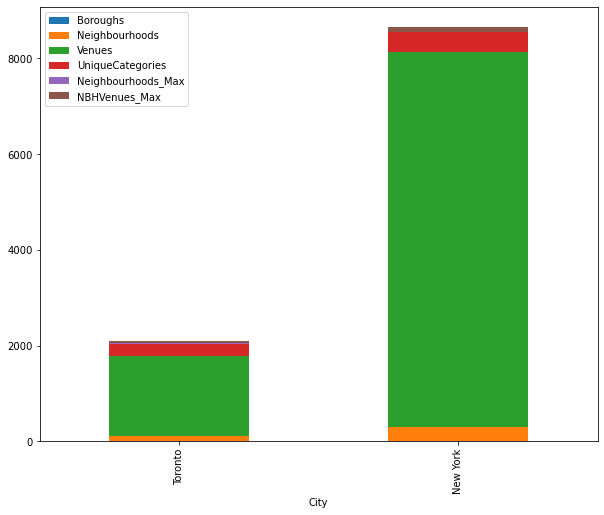

In [146]:
stat1_df.plot(x="City", y=['Boroughs','Neighbourhoods','Venues','UniqueCategories', 'Neighbourhoods_Max','NBHVenues_Max'], kind='bar', stacked=True,figsize=(10,8))
#stat1_df.plot(x='City', y='Neighbourhoods_Max', kind='bar') 
plt.show()

# End-of-Case-Program